In [1]:
%matplotlib inline

In [2]:
import numpy as np
import argparse
import sys

from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_svmlight_file
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from kernel_regression import KernelLogit

from ope_estimators import OPEestimators

In [3]:
def data_generation(data_name, N):
    X, Y = load_svmlight_file('data/{}'.format(data_name))
    X = X.toarray()
    maxX = X.max(axis=0)
    maxX[maxX == 0] = 1
    X = X / maxX
    Y = np.array(Y, np.int64)

    perm = np.random.permutation(len(X))

    X, Y = X[perm[:N]], Y[perm[:N]]

    if data_name == 'satimage':
        Y = Y - 1
    elif data_name == 'vehicle':
        Y = Y - 1
    elif data_name == 'mnist':
        pca = PCA(n_components=100).fit(X)
        X = pca.transform(X)
    elif data_name == 'letter':
        Y = Y - 1
    elif data_name == 'Sensorless':
        Y = Y - 1
    elif data_name == 'connect-4':
        Y = Y + 1

    classes = np.unique(Y)

    Y_matrix = np.zeros(shape=(N, len(classes)))

    for i in range(N):
        Y_matrix[i, Y[i]] = 1

    return X, Y, Y_matrix, classes


def fit_logreg(X, Y):
    return LogisticRegression(random_state=0, penalty='l2', C=0.1, solver='saga', multi_class='multinomial').fit(X, Y)


def create_policy(X, classes, classifier, alpha=0.7):
    N = len(X)
    num_class = len(classes)

    predict = np.array(classifier.predict(X), np.int64)

    pi_predict = np.zeros(shape=(N, num_class))

    for i in range(N):
        pi_predict[i, predict[i]] = 1

    pi_random = np.random.uniform(size=(N, num_class))

    pi_random = pi_random.T
    pi_random /= pi_random.sum(axis=0)
    pi_random = pi_random.T

    policy = alpha * pi_predict + (1 - alpha) * pi_random

    return policy


class Basic(object):
    def __init__(self, num_arm, T):
        self.num_arm = num_arm
        self.sum_of_reward = np.zeros(num_arm)
        self.num_of_trial = np.zeros(num_arm)
        self.T = T


class UCB(Basic):
    def __init__(self, num_arm, T, dim, sigma2_0=1, sigma2=1, alpha=1):
        super().__init__(num_arm, T)
        self.ucb_score = np.zeros(num_arm)
        self.identity = np.identity(dim)

        self.sigma2_0 = sigma2_0
        self.sigma2 = sigma2

        self.A_inv_array = [(self.sigma2_0/self.sigma2) *
                            self.identity for i in range(num_arm)]

        self.b_array = [np.zeros((dim, 1)) for i in range(num_arm)]

        self.alpha = alpha

    def __call__(self, t, covariate):
        alpha_t = self.alpha*np.sqrt(np.log(t+1))

        for arm in range(self.num_arm):
            theta = self.A_inv_array[arm].dot(self.b_array[arm])
            m0 = covariate.T.dot(theta)
            m1 = alpha_t * \
                np.sqrt(
                    self.sigma2)*np.sqrt(covariate.T.dot(self.A_inv_array[arm]).dot(covariate))
            self.ucb_score[arm] = m0 + m1

        return np.argmax(self.ucb_score)

    def update(self, arm, reward, covariate):
        self.sum_of_reward[arm] += reward
        self.num_of_trial[arm] += 1

        A_inv_temp = self.A_inv_array[arm].copy()
        A_inv_temp0 = A_inv_temp.dot(covariate).dot(
            covariate.T).dot(A_inv_temp)
        A_inv_temp1 = 1+covariate.T.dot(A_inv_temp).dot(covariate)
        self.A_inv_array[arm] -= A_inv_temp0/A_inv_temp1

        self.b_array[arm] += covariate*reward


class TS(Basic):
    def __init__(self, num_arm, T, dim, sigma2_0=1, sigma2=1, alpha=1):
        super().__init__(num_arm, T)
        self.ucb_score = np.zeros(num_arm)
        self.identity = np.identity(dim)

        self.sigma2_0 = sigma2_0
        self.sigma2 = sigma2

        self.A_inv_array = [(self.sigma2_0/self.sigma2) *
                            self.identity for i in range(num_arm)]

        self.b_array = [np.zeros((dim, 1)) for i in range(num_arm)]

        self.alpha = alpha

    def __call__(self, t, covariate):

        for arm in range(self.num_arm):
            mu = self.A_inv_array[arm].dot(self.b_array[arm])

            theta = np.random.multivariate_normal(
                mu.T[0], self.sigma2*self.A_inv_array[arm])

            self.ucb_score[arm] = covariate.T.dot(theta)

        return np.argmax(self.ucb_score)

    def update(self, arm, reward, covariate):
        self.sum_of_reward[arm] += reward
        self.num_of_trial[arm] += 1

        A_inv_temp = self.A_inv_array[arm].copy()
        A_inv_temp0 = A_inv_temp.dot(covariate).dot(
            covariate.T).dot(A_inv_temp)
        A_inv_temp1 = 1+covariate.T.dot(A_inv_temp).dot(covariate)
        self.A_inv_array[arm] -= A_inv_temp0/A_inv_temp1

        self.b_array[arm] += covariate*reward


def create_bandit_policy(X, classes, Y, policy_type='RW', predct_alg='Logit', tau=0.7):
    sample_size, dim = X.shape
    num_actions = len(classes)

    chosen_action_matrix = np.zeros(shape=(sample_size, num_actions))
    observed_outcome_matrix = np.zeros(shape=(sample_size, num_actions))

    if policy_type == 'UCB':
        pi_behavior_array = np.zeros((sample_size, num_actions))
        next_candidate = np.random.uniform(0.01, 0.99, size=(1, num_actions))
        next_candidate = next_candidate/np.sum(next_candidate)
        pi_behavior_array[0] = next_candidate

        ucb = UCB(num_arm=num_actions, T=sample_size,
                  dim=dim, sigma2_0=5, sigma2=5)

        for time in range(sample_size):
            covariate_t = np.array([X[time]]).T

            arm = ucb(time, covariate_t)
            uni_rand = np.random.uniform(size=(num_actions))
            uni_rand = uni_rand/np.sum(uni_rand)
            prob = (1-tau)*uni_rand
            prob[arm] += tau

            pi_behavior_array[time] = prob

            chosen_action = np.random.choice(
                classes, p=pi_behavior_array[time])
            observed_outcome = Y[time, chosen_action]

            chosen_action_matrix[time, chosen_action] = 1
            observed_outcome_matrix[time,
                                    chosen_action] = observed_outcome

            ucb.update(chosen_action,
                       observed_outcome, covariate_t)

    if policy_type == 'TS':
        pi_behavior_array = np.zeros((sample_size, num_actions))
        next_candidate = np.random.uniform(0.01, 0.99, size=(1, num_actions))
        next_candidate = next_candidate/np.sum(next_candidate)
        pi_behavior_array[0] = next_candidate

        ts = TS(num_arm=num_actions, T=sample_size,
                dim=dim, sigma2_0=1, sigma2=1)

        for time in range(sample_size):
            covariate_t = np.array([X[time]]).T

            arm = ts(time, covariate_t)
            uni_rand = np.random.uniform(size=(num_actions))
            uni_rand = uni_rand/np.sum(uni_rand)

            prob = (1-tau)*uni_rand
            prob[arm] += tau

            pi_behavior_array[time] = prob

            chosen_action = np.random.choice(
                classes, p=prob)
            observed_outcome = Y[time, chosen_action]

            chosen_action_matrix[time, chosen_action] = 1
            observed_outcome_matrix[time,
                                    chosen_action] = observed_outcome

            ts.update(chosen_action,
                      observed_outcome, covariate_t)

    return pi_behavior_array, observed_outcome_matrix, chosen_action_matrix


def true_value(Y_matrix, pi_evaluation):
    return np.sum(Y_matrix * pi_evaluation) / len(pi_evaluation)


def sample_by_behavior(Y_matrix, pi_behavior, classes):
    sample_size = len(Y_matrix)
    Y_observed_matrix = np.zeros(shape=(sample_size, len(classes)))
    A_observed_matrix = np.zeros(shape=(sample_size, len(classes)))

    for i in range(sample_size):
        a = np.random.choice(classes, p=pi_behavior[i])
        Y_observed_matrix[i, a] = Y_matrix[i, a]
        A_observed_matrix[i, a] = 1

    return Y_observed_matrix, A_observed_matrix

In [60]:
KernelRidge_hyp_param = {'alpha': [0.01, 0.1, 1], 'gamma': [0.01, 0.1, 1]}
KernelLogit_sigma_list = np.array([0.01, 0.1, 1])
KernelLogit_lda_list = np.array([0.01, 0.1, 1])


def kernel_ridge_estimator(X, Y, Z, cv=5):
    model = KernelRidge(kernel='rbf')
    model = GridSearchCV(
        model, {'alpha': [0.01, 0.1, 1], 'gamma': [0.01, 0.1, 1]}, cv=cv)
    model.fit(X, Y)
    return model.predict(Z)


def kernel_logit_estimator(X, Y, Z, cv=5):
    model, KX, KZ = KernelLogit(X, Y, Z, folds=cv, num_basis=100,
                                sigma_list=KernelLogit_sigma_list,
                                lda_list=KernelLogit_lda_list, algorithm='Ridge')
    model.fit(KX, Y)
    return model.predict_proba(KZ)


class OPEestimators():
    def __init__(self, classes, pi_evaluation, pi_behavior=None):
        self.classes = classes
        self.pi_behavior = pi_behavior
        self.pi_evaluation = pi_evaluation

    def fit(self, X, A, Y_matrix, est_type,
            outcome_estimator=kernel_ridge_estimator,
            policy_estimator=kernel_logit_estimator,
            warning_samples=10):
        self.X = X
        self.N_hst, self.dim = X.shape
        self.A = A
        self.Y = Y_matrix
        self.warning_samples = warning_samples

        self.outcome_estimator = kernel_ridge_estimator
        self.policy_estimator = kernel_logit_estimator

        warnings.simplefilter('ignore')

        if est_type == 'ipw':
            theta, var  = self.ipw()
        if est_type == 'dm':
            theta, var  = self.dm()
        if est_type == 'aipw':
            theta, var  = self.aipw()
        if est_type == 'a2ipw':
            theta, var  = self.a2ipw()
        if est_type == 'adr':
            theta, var = self.adr()
        if est_type == 'dr':
            theta, var = self.dr()
        if est_type == 'doublyrobust':
            theta, var = self.doublyrobust()

        return theta, var

    def aipw(self, folds=2):
        theta_list = []

        cv_fold = np.arange(folds)
        cv_split0 = np.floor(np.arange(self.N_hst)*folds/self.N_hst)
        cv_index = cv_split0[np.random.permutation(self.N_hst)]

        x_cv = []
        a_cv = []
        y_cv = []
        pi_bhv_cv = []
        pi_evl_cv = []

        for k in cv_fold:
            x_cv.append(self.X[cv_index == k])
            a_cv.append(self.A[cv_index == k])
            y_cv.append(self.Y[cv_index == k])

            pi_bhv_cv.append(self.pi_behavior[cv_index == k])
            pi_evl_cv.append(self.pi_evaluation[cv_index == k])

        for k in range(folds):
            count = 0
            for j in range(folds):
                if j == k:
                    x_te = x_cv[j]
                    a_te = a_cv[j]
                    y_te = y_cv[j]
                    pi_bhv_te = pi_bhv_cv[j]
                    pi_evl_te = pi_evl_cv[j]

                if j != k:
                    if count == 0:
                        x_tr = x_cv[j]
                        a_tr = a_cv[j]
                        y_tr = y_cv[j]
                        pi_bhv_tr = pi_bhv_cv[j]
                        pi_evl_tr = pi_evl_cv[j]
                        count += 1
                    else:
                        x_tr = np.append(x_tr, x_cv[j], axis=0)
                        a_tr = np.append(a_tr, a_cv[j], axis=0)
                        y_tr = np.append(y_tr, y_cv[j], axis=0)
                        pi_bhv_tr = np.append(pi_bhv_tr, pi_bhv_cv[j], axis=0)
                        pi_evl_tr = np.append(pi_evl_tr, pi_evl_cv[j], axis=0)

            densratio_matrix = pi_evl_te/pi_bhv_te

            f_matrix = np.zeros(shape=(len(x_te), len(self.classes)))

            for c in self.classes:
                f_matrix[:, c] = self.outcome_estimator(
                    x_tr[a_tr[:, c] == 1], y_tr[:, c][a_tr[:, c] == 1], x_te)

            # weight = np.ones(shape=a_te.shape)*np.sum(a_te/pi_bhv_te, axis=0)
            weight = len(a_te)
            theta = np.sum(a_te*(y_te-f_matrix)*densratio_matrix /
                           weight) + np.sum(f_matrix*pi_evl_te/weight)

            theta_list.append(theta)

        theta =  np.mean(theta_list)
            
        densratio_matrix = self.pi_evaluation/self.pi_behavior

        f_matrix = np.zeros(shape=(self.N_hst, len(self.classes)))

        for c in self.classes:
            for t in range(self.N_hst):
                if np.sum(self.A[:t, c] == 1) > self.warning_samples:
                    f_matrix[t, c] = self.outcome_estimator(
                        self.X[:t][self.A[:t, c] == 1],
                        self.Y[:t][:t, c][self.A[:t, c] == 1],
                        [self.X[t]])
                else:
                    f_matrix[t, c] = 0

        # weight = np.ones(shape=a_te.shape)*np.sum(a_te/pi_bhv_te, axis=0)
        score = np.sum(self.A*(self.Y-f_matrix)*densratio_matrix, axis=1) + np.sum(f_matrix*self.pi_evaluation, axis=1)
        
        var = np.mean((score - theta)**2)

        return theta, var

    def dr(self, folds=2):
        theta_list = []

        cv_fold = np.arange(folds)
        cv_split0 = np.floor(np.arange(self.N_hst)*folds/self.N_hst)
        cv_index = cv_split0[np.random.permutation(self.N_hst)]

        x_cv = []
        a_cv = []
        y_cv = []
        pi_evl_cv = []

        for k in cv_fold:
            x_cv.append(self.X[cv_index == k])
            a_cv.append(self.A[cv_index == k])
            y_cv.append(self.Y[cv_index == k])

            pi_evl_cv.append(self.pi_evaluation[cv_index == k])

        for k in range(folds):
            count = 0
            for j in range(folds):
                if j == k:
                    x_te = x_cv[j]
                    a_te = a_cv[j]
                    y_te = y_cv[j]
                    pi_evl_te = pi_evl_cv[j]

                if j != k:
                    if count == 0:
                        x_tr = x_cv[j]
                        a_tr = a_cv[j]
                        y_tr = y_cv[j]
                        pi_evl_tr = pi_evl_cv[j]
                        count += 1
                    else:
                        x_tr = np.append(x_tr, x_cv[j], axis=0)
                        a_tr = np.append(a_tr, a_cv[j], axis=0)
                        y_tr = np.append(y_tr, y_cv[j], axis=0)
                        pi_evl_tr = np.append(pi_evl_tr, pi_evl_cv[j], axis=0)

            a_temp = np.where(a_tr == 1)[1]
            pi_bhv_te = kernel_logit_estimator(
                x_tr, a_temp, x_te)

            densratio_matrix = pi_evl_te/pi_bhv_te

            f_matrix = np.zeros(shape=(len(x_te), len(self.classes)))

            for c in self.classes:
                f_matrix[:, c] = self.outcome_estimator(
                    x_tr[a_tr[:, c] == 1], y_tr[:, c][a_tr[:, c] == 1], x_te)

            # weight = np.ones(shape=a_te.shape)*np.sum(a_te/pi_bhv_te, axis=0)
            weight = len(a_te)
            theta = np.sum(a_te*(y_te-f_matrix)*densratio_matrix /
                           weight) + np.sum(f_matrix*pi_evl_te/weight)

            theta_list.append(theta)
            
        theta =  np.mean(theta_list)
        
        a_temp = np.where(self.A == 1)[1]
        pi_behavior = kernel_logit_estimator(self.X, a_temp, self.X)
            
        densratio_matrix = self.pi_evaluation/pi_behavior

        f_matrix = np.zeros(shape=(self.N_hst, len(self.classes)))

        for c in self.classes:
            for t in range(self.N_hst):
                if np.sum(self.A[:t, c] == 1) > self.warning_samples:
                    f_matrix[t, c] = self.outcome_estimator(
                        self.X[:t][self.A[:t, c] == 1],
                        self.Y[:t][:t, c][self.A[:t, c] == 1],
                        [self.X[t]])
                else:
                    f_matrix[t, c] = 0

        # weight = np.ones(shape=a_te.shape)*np.sum(a_te/pi_bhv_te, axis=0)
        score = np.sum(self.A*(self.Y-f_matrix)*densratio_matrix, axis=1) + np.sum(f_matrix*self.pi_evaluation, axis=1)
        
        var = np.mean((score - theta)**2)

        return theta, var

    def a2ipw(self):
        densratio_matrix = self.pi_evaluation/self.pi_behavior

        f_matrix = np.zeros(shape=(self.N_hst, len(self.classes)))

        for c in self.classes:
            for t in range(self.N_hst):
                if np.sum(self.A[:t, c] == 1) > self.warning_samples:
                    f_matrix[t, c] = self.outcome_estimator(
                        self.X[:t][self.A[:t, c] == 1],
                        self.Y[:t][:t, c][self.A[:t, c] == 1],
                        [self.X[t]])
                else:
                    f_matrix[t, c] = 0

        # weight = np.ones(shape=a_te.shape)*np.sum(a_te/pi_bhv_te, axis=0)
        score = np.sum(self.A*(self.Y-f_matrix)*densratio_matrix, axis=1) + np.sum(f_matrix*self.pi_evaluation, axis=1)
        
        theta = np.mean(score)
        var = np.mean((score - theta)**2)

        return theta, var

    def adr(self):
        theta_list = []

        pi_behavior = np.copy(self.pi_evaluation)
        pi_behavior[:] = 0.5

        for t in range(1, self.N_hst):
            if all(np.sum(self.A[:t, :] == 1, axis=0) > self.warning_samples):
                a_temp = np.where(self.A[:t] == 1)[1]
                pi_behavior[t, :] = kernel_logit_estimator(
                    self.X[:t], a_temp, np.array([self.X[t]]))

            else:
                pi_behavior[t, :] = 0.5

        densratio_matrix = self.pi_evaluation/pi_behavior

        f_matrix = np.zeros(shape=(self.N_hst, len(self.classes)))

        for c in self.classes:
            for t in range(self.N_hst):
                if np.sum(self.A[:t, c] == 1) > self.warning_samples:
                    f_matrix[t, c] = self.outcome_estimator(
                        self.X[:t][self.A[:t, c] == 1],
                        self.Y[:t][:t, c][self.A[:t, c] == 1],
                        [self.X[t]])
                else:
                    f_matrix[t, c] = 0

        # weight = np.ones(shape=a_te.shape)*np.sum(a_te/pi_bhv_te, axis=0)
        score = np.sum(self.A*(self.Y-f_matrix)*densratio_matrix, axis=1) + np.sum(f_matrix*self.pi_evaluation, axis=1)
        
        theta = np.mean(score)
        var = np.mean((score - theta)**2)

        return theta, var

    def ipw(self):
        if self.pi_behavior is None:
            a_temp = np.where(self.A == 1)[1]
            self.pi_behavior = kernel_logit_estimator(self.X, a_temp, self.X)

        densratio = self.pi_evaluation/self.pi_behavior

        # weight = np.ones(shape=self.A.shape)*np.sum(self.A/self.pi_behavior, axis=0)
        weight = len(self.A)
        
        score = np.sum(self.A*self.Y*densratio, axis=1)
        
        theta = np.mean(score)
        var = np.mean((score - theta)**2)

        return theta, var
    
    def doublyrobust(self):
        a_temp = np.where(self.A == 1)[1]
        pi_behavior = kernel_logit_estimator(self.X, a_temp, self.X)

        densratio = self.pi_evaluation/pi_behavior
        
        f_matrix = np.zeros(shape=(self.N_hst, len(self.classes)))

        for c in self.classes:
            f_matrix[:, c] = self.outcome_estimator(
                self.X[self.A[:, c] == 1],
                self.Y[:, c][self.A[:, c] == 1],
                self.X)

        # weight = np.ones(shape=self.A.shape)*np.sum(self.A/self.pi_behavior, axis=0)
        
        score = np.sum(self.A*(self.Y-f_matrix)*densratio, axis=1) + np.sum(f_matrix*self.pi_evaluation, axis=1)
        
        theta = np.mean(score)
        var = np.mean((score - theta)**2)

        return theta, var

    def dm(self, method='Ridge'):
        f_matrix = np.zeros(shape=(self.N_hst, len(self.classes)))

        for c in self.classes:
            f_matrix[:, c] = self.outcome_estimator(
                self.X[self.A[:, c] == 1],
                self.Y[:, c][self.A[:, c] == 1],
                self.X)
        
        score = np.sum(f_matrix*self.pi_evaluation, axis=1)
        theta = np.mean(score)
        var = np.mean((score - theta)**2)

        return theta, var
    

In [61]:
def data_generator(N=1000):
    X = np.random.normal(size=(N, 10))
    g0 = np.sum(X, axis=1)
    g1 = np.sum(np.random.choice([-1, 1], size=(N, 10))*X**2, axis=1)
    g2 = np.sum(np.random.choice([-1, 1], size=(N, 10))*np.abs(X), axis=1)

    prob_array = np.zeros(shape=(N, 3))
    prob_array[:, 0] = np.exp(g0)
    prob_array[:, 1] = np.exp(g1)
    prob_array[:, 2] = np.exp(g2)

    prob_array = (prob_array.T/prob_array.sum(axis=1)).T

    Y = np.zeros(shape=(N, 1))

    for i in range(N):
        Y[i] = np.random.choice([0, 1, 2], p=prob_array[i])
    
    Y = np.array(Y, np.int64)
    Y_matrix = np.zeros(shape=(N, 3))

    for i in range(N):
        Y_matrix[i, Y[i]] = 1
    
    return X, Y, Y_matrix

In [62]:
history_sample_size = 50
evaluation_policy_size = 100

policy_type = 'TS'

classes = [0, 1, 2]
num_trials = 1000

logit_model = LogisticRegression(random_state=0, C=0.1)

method_list = [logit_model]

true_list = []

est_ipw_list = []
est_dm_list = []
est_aipw_list = []
est_a2ipw_list = []
est_est_ipw_list = []
est_dr_list = []
est_doubly_robust_list = []
est_adr_list = []

for tr in range(num_trials):
    print(tr)
    
    X, Y_true, Y_true_matrix = data_generator(evaluation_policy_size + history_sample_size)
    X_pre = X[:evaluation_policy_size]
    Y_pre_true = Y_true[:evaluation_policy_size]
    _ = Y_true_matrix[:evaluation_policy_size]

    X_hist = X[evaluation_policy_size:]
    _ = Y_true[evaluation_policy_size:]
    Y_hist_true_matrix = Y_true_matrix[evaluation_policy_size:]

    classifier = fit_logreg(X_pre, Y_pre_true)

    pi_evaluation = create_policy(
        X_hist, classes, classifier, alpha=0.9)
    
    pi_behavior, Y_hist, A_hist = create_bandit_policy(
            X_hist, classes,  Y_hist_true_matrix, policy_type=policy_type, tau=0.7)
    
    true_val = true_value(Y_hist_true_matrix, pi_evaluation)
    
    OPE = OPEestimators( classes, pi_evaluation=pi_evaluation, pi_behavior=pi_behavior)
    
    true_list.append(true_val)
    
    est_ipw_list.append(OPE.fit(X_hist, A_hist, Y_hist, est_type='ipw') )
    est_dm_list.append(OPE.fit(X_hist, A_hist, Y_hist, est_type='dm') )
    est_aipw_list.append(OPE.fit(X_hist, A_hist, Y_hist, est_type='aipw') )
    est_a2ipw_list.append(OPE.fit(X_hist, A_hist, Y_hist, est_type='a2ipw'))
    
    OPE = OPEestimators( classes, pi_evaluation=pi_evaluation, pi_behavior=None)
    est_est_ipw_list.append(OPE.fit(X_hist, A_hist, Y_hist, est_type='ipw') )
    est_dr_list.append(OPE.fit(X_hist, A_hist, Y_hist, est_type='dr') )
    est_doubly_robust_list.append(OPE.fit(X_hist, A_hist, Y_hist, est_type='doublyrobust') )
    est_adr_list.append(OPE.fit(X_hist, A_hist, Y_hist, est_type='adr'))

0
1
2
3
4


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.

In [63]:
num_trials

1000

In [84]:
true_list_array = np.array(true_list)

est_ipw_list_array = np.array(est_ipw_list)
est_dm_list_array = np.array(est_dm_list)
est_aipw_list_array = np.array(est_aipw_list)
est_a2ipw_list_array = np.array(est_a2ipw_list)
est_dr_list_array = np.array(est_dr_list)
est_adr_list_array = np.array(est_adr_list)
est_doubly_robust_list_array = np.array(est_doubly_robust_list)

In [85]:
error0 = est_ipw_list_array[:, 0] - true_list_array
error1 = est_dm_list_array[:, 0] - true_list_array
error2 = est_aipw_list_array[:, 0] - true_list_array
error3 = est_a2ipw_list_array[:, 0]- true_list_array
error4 = est_dr_list_array[:, 0] - true_list_array
error5 = est_adr_list_array[:, 0] - true_list_array
error6 = est_doubly_robust_list_array[:, 0] - true_list_array

ValueError: operands could not be broadcast together with shapes (4,) (5,) 

In [86]:
error0 = est_ipw_list_array[:, 0] - true_list_array
error1 = est_dm_list_array[:, 0] - true_list_array
error2 = est_aipw_list_array[:, 0] - true_list_array[:-1]
error3 = est_a2ipw_list_array[:, 0]- true_list_array[:-1]
error4 = est_dr_list_array[:, 0] - true_list_array[:-1]
error5 = est_adr_list_array[:, 0] - true_list_array[:-1]
error6 = est_doubly_robust_list_array[:, 0] - true_list_array[:-1]

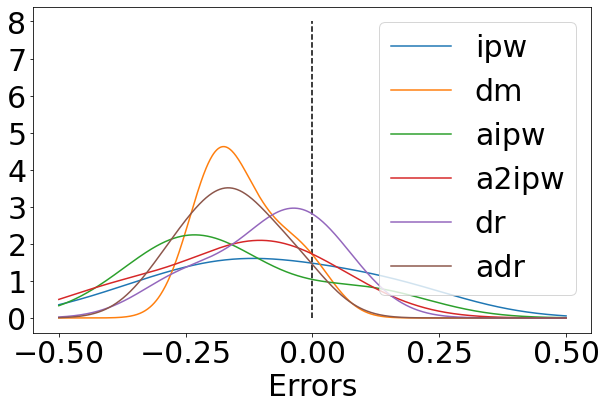

In [87]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

limmin = -0.5
limmax = 0.5
ls = np.linspace(limmin, limmax, 1000)

kde = gaussian_kde(error0)
plt.plot(ls, kde(ls), label='ipw')

kde = gaussian_kde(error1)
plt.plot(ls, kde(ls), label='dm')

kde = gaussian_kde(error2)
plt.plot(ls, kde(ls), label='aipw')

kde = gaussian_kde(error3)
plt.plot(ls, kde(ls), label='a2ipw')

kde = gaussian_kde(error4)
plt.plot(ls, kde(ls), label='dr')

kde = gaussian_kde(error5)
plt.plot(ls, kde(ls), label='adr')

p = plt.vlines([0], 0, 8, "black", linestyles='dashed') 
plt.xlabel('Errors', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks([-0.5, -0.25, 0, 0.25, 0.5])
plt.xticks(fontsize=30)
plt.legend(fontsize=30)

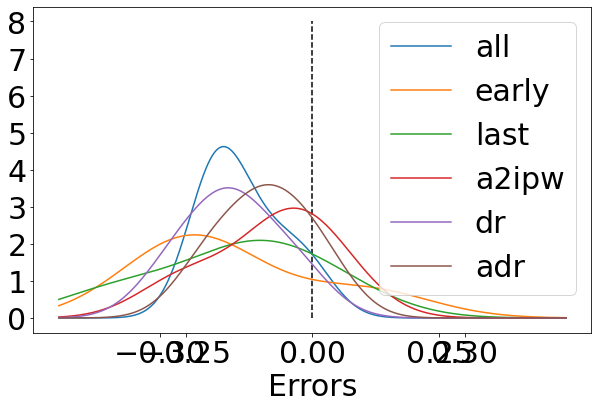

In [89]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

limmin = -0.5
limmax = 0.5
ls = np.linspace(limmin, limmax, 1000)

kde = gaussian_kde(error1)
plt.plot(ls, kde(ls), label='all')

kde = gaussian_kde(error2[:20])
plt.plot(ls, kde(ls), label='early')

kde = gaussian_kde(error3[:30])
plt.plot(ls, kde(ls), label='last')

kde = gaussian_kde(error4[:40])
plt.plot(ls, kde(ls), label='a2ipw')

kde = gaussian_kde(error5[:50])
plt.plot(ls, kde(ls), label='dr')

kde = gaussian_kde(error6[:])
plt.plot(ls, kde(ls), label='adr')

p = plt.vlines([0], 0, 8, "black", linestyles='dashed') 
plt.xlabel('Errors', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks([-0.3, -0.25, 0, 0.25, 0.3])
plt.xticks(fontsize=30)
plt.legend(fontsize=30)

In [78]:
error2

array([ 0.102264  , -0.19287588, -0.27243625, -0.24511647])

In [38]:
np.mean(error0)

0.006998333969704001

In [42]:
np.mean(error0**2)

0.10371661874682434

In [49]:
np.mean(error2)

0.0028896052753332496

In [41]:
np.mean(error3)

0.006845897893574099

In [43]:
np.mean(error3**2)

0.06289666220489809

In [44]:
np.mean(error4)

0.002918562158550399

In [46]:
np.mean(error4**2)

0.007615721788877985

In [45]:
np.mean(error5)

-0.054894342029557924

In [47]:
np.mean(error5**2)

0.00824473728298613

In [48]:
np.mean(error1**2)

0.009675056580888975

In [31]:
from scipy import stats
np.random.seed(12345678)
x = stats.norm.rvs(loc=5, scale=3, size=100)
stats.shapiro(x)

(0.9772805571556091, 0.08144091814756393)